# 0. Imports and presteps

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
import torch.optim as optim
import time
import matplotlib.pyplot as plt

Use CUDA to to use colab GPU (Standard).

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# 1. Read dataset and create dataloaders

Firstly I create the data augmentation transformations

In [3]:
aug_1 = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(32, scale=(0.8, 1.2)),
    transforms.ToTensor()
])

aug_2 = transforms.Compose([
    transforms.RandomAffine(30, translate=(0.3, 0.3), scale=(0.8, 1.2)),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.2)], p=0.5),
    transforms.RandomResizedCrop(32, scale=(0.8, 1.2)),
    transforms.ToTensor()
])

In [4]:
def get_cifar_train():
  ## Gets cifar10 training data and applies the above augmentations and combines
  ## with the original training set to give a final training set size of 150000.
  t1 = datasets.CIFAR10(root="data", train=True,
                                download=True, transform=transforms.ToTensor())
  
  t2 = datasets.CIFAR10(root="data", train=True,
                                download=True, transform=aug_1)

  t3 = datasets.CIFAR10(root="data", train=True,
                                download=True, transform=aug_2)
  
  return t1 + t2 + t3

Get the CIFAR10 training and test data

In [5]:
training_set = get_cifar_train()

test_set = datasets.CIFAR10(root="data", train=False,
                            download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [6]:
len(training_set)  ## reality check: 150000

150000

I will now create the dataloaders

In [7]:
batch_size = 256  ## determined through experimentation that this was the best.

In [8]:
train_dataloader = DataLoader(training_set, batch_size=batch_size)
test_dataloader = DataLoader(test_set, batch_size=batch_size)

I will now print out an instance of the training set for a reality check.

In [9]:
for X, y in train_dataloader:
  print(X.shape)    ## reality check: (256, 3, 32, 32)
  print(y.shape)    ## reality check: (256)
  break

torch.Size([256, 3, 32, 32])
torch.Size([256])


In [10]:
len(train_dataloader.dataset)  ## reality check: 150000

150000

Each image is a 3x32x32 image, where 32x32 is the size of the image and 3 is the channel size.

# 2. Create the model

Convolution - Convolution with some extra details to simplify.

In [11]:
class Convolution(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride, padding, device, dropout_rate):
    super(Convolution, self).__init__()

    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=padding, device=device)
    nn.init.xavier_normal_(self.conv.weight)
    self.batchNorm = nn.BatchNorm2d(out_channels, device=device)
    self.activation = nn.ReLU()
    self.dropout = nn.Dropout(p=dropout_rate)

  def forward(self, x):
    x = self.conv(x)
    x = self.batchNorm(x)
    x = self.activation(x)
    x = self.dropout(x)
    return x

**Block** - The block used in the backbone



> This block does everything as stated in the assignment brief. It also allows for the option of a residual connection.



In [12]:
class Block(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_sizes, strides, padding, device, dropout_rate, skip_connection, adding_skip):
    super(Block, self).__init__()
    self.adding_skip = adding_skip
    self.skip_connection = skip_connection
    self.dense_size = len(kernel_sizes) ### This is the same as K
    self.linear = nn.Linear(in_channels, self.dense_size, device=device)
    self.spatialAvgPool = nn.AdaptiveAvgPool2d((1,1))
    self.activation = nn.ReLU()
    self.convolutions = nn.ModuleList([Convolution(in_channels, out_channels, kernel_sizes[i], strides[i], padding=padding, device=device, dropout_rate=dropout_rate) for i in range(self.dense_size)])

  def forward(self, x1, x2=None):
    if self.adding_skip == True:
      x = torch.add(x1, x2)
    else:
      x = x1
    y = self.spatialAvgPool(x)
    y = y.view(y.size(0), y.size(1))
    y = self.linear(y)
    y = self.activation(y)
    y = torch.reshape(y, (-1, self.dense_size, 1, 1, 1))
    convs = [self.convolutions[i](x) for i in range(self.dense_size)]
    for i in range(self.dense_size):
      convs[i] = torch.mul(convs[i], y[:, i])
    out = sum(convs)
    if self.skip_connection == True:
      return out, x
    else:
      return out

**Classifier** - This defines the classification part of the model.



> This block contains everything as stated in the assignment brief.



In [13]:
class Classifier(nn.Module):
  def __init__(self, in_channels):
    super(Classifier, self).__init__()
    self.spatialAvgPool = nn.AdaptiveAvgPool2d((1,1))
    ####  Anything extra should be  ####
    ####  added in this code block  ####

    ####################################
    ####################################
    self.classifier = nn.Linear(in_channels, 10, device=device)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, x):
    x = self.spatialAvgPool(x)
    x = x.view(x.size(0), x.size(1))
    ####  Anything extra should be  ####
    ####  added in this code block  ####


    ####################################
    ####################################
    x = self.classifier(x)
    x = self.softmax(x)
    return x

**Backbone** - Encapsulates all the Blocks used the in backbone.

In [14]:
class Backbone(nn.Module):
  def __init__(self):
    super(Backbone, self).__init__()
    ####  Anything extra should be  ####
    ####  added in this code block  ####
    self.block1 = Block(3, 16, [3]*3, [1]*3, "same", device, 0.1, False, False)
    self.block2 = Block(16, 32, [3]*3, [2]*3, 1, device, 0.1, False, False)
    self.block3 = Block(32, 64, [3]*3, [1]*3, "same", device, 0.1, False, False)
    self.block4 = Block(64, 32, [3]*3, [1]*3, "same", device, 0.1, True, False)
    self.block5 = Block(32, 48, [3]*3, [2]*3, 1, device, 0.1, False, False)
    self.block6 = Block(48, 64, [3]*3, [1]*3, "same", device, 0.1, False, False)
    self.block7 = Block(64, 64, [3]*3, [1]*3, "same", device, 0.1, False, True)
    self.block8 = Block(64, 64, [3]*3, [1]*3, "same", device, 0.1, False, False)
    
    self.residual = Convolution(64, 64, 3, 2, 1, device, 0.1)
    ####################################
    ####################################

  def forward(self, x):
    ####  Anything extra should be  ####
    ####  added in this code block  ####
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    x, skip = self.block4(x)
    skip = self.residual(skip)
    x = self.block5(x)
    x = self.block6(x)
    x = self.block7(x, skip)
    x = self.block8(x)
    ####################################
    ####################################
    return x

**Model** - Uses the Backbone and Classifier class to create the final model to be used.

In [15]:
class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()

    self.backbone = Backbone().to(device)
    self.classifier = Classifier(64).to(device)

  def forward(self,x):
    x = self.backbone(x)
    x = self.classifier(x)
    return x

Create the model:

In [16]:
model = Model().to(device)

# 3. Create the loss and the optimizer

For the loss I will use Cross Entropy Loss

In [17]:
criterion = nn.CrossEntropyLoss()

Optimizer be Adam with a weight decay of 0.0001.

In [18]:
optimizer = optim.Adam(model.parameters(), weight_decay=0.0001)

I will also use the ReduceLROnPlateau learning rate scheduler.

In [19]:
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)

# 4. Write the training script to train the model.

In [20]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

Set epochs and intialize the storage of the model history.

In [21]:
epochs = 60

In [22]:
train_accuracies = []
train_losses = []
val_accuracies = []
val_losses = []
lrs = []

This next part deines the training script

In [23]:
print("Starting Training!\n")
for epoch in range(epochs):
  t0 = time.time()
  model.train()
  running_loss = 0.0
  running_counter = 0
  running_correct= 0 
  for i, data in enumerate(train_dataloader, 0):
    inputs, labels = data
    inputs = inputs.cuda()
    labels = labels.cuda()
    
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item() * inputs.size(0)
    running_counter += inputs.size(0)

    _, predicted = torch.max(outputs.data, 1)
    running_correct += (predicted == labels).sum().item()
  train_losses.append(running_loss/len(train_dataloader.dataset))
  train_accuracies.append(running_correct/running_counter)
  
  running_loss = 0.0
  running_correct = 0
  running_counter = 0
  model.eval()
  with torch.no_grad():
    for i, data in enumerate(test_dataloader, 0):
      inputs, labels = data
      inputs = inputs.cuda()
      labels = labels.cuda()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      running_loss += loss.item() * inputs.size(0)
      running_counter += inputs.size(0)

      _, predicted = torch.max(outputs.data, 1)
      running_correct += (predicted == labels).sum().item()
  val_losses.append(running_loss/len(test_dataloader.dataset))
  val_accuracies.append(running_correct/running_counter)
  lrs.append(get_lr(optimizer))
  scheduler.step(val_losses[-1])
  
  print("##############################################################################################################")
  print(f"Epoch {epoch+1}/{epochs} ({time.time()-t0:.2f}s), Train loss: {train_losses[-1]:.5f}, Train acc: {train_accuracies[-1]:.5f}, Val loss: {val_losses[-1]:.5f}, Val acc: {val_accuracies[-1]:.5f}, lr: {lrs[-1]:.5f}.")



Starting Training!

##############################################################################################################
Epoch 1/60 (109.49s), Train loss: 2.10843, Train acc: 0.34325, Val loss: 2.05791, Val acc: 0.39750, lr: 0.00100.
##############################################################################################################
Epoch 2/60 (105.15s), Train loss: 2.00363, Train acc: 0.45214, Val loss: 2.01153, Val acc: 0.44270, lr: 0.00100.
##############################################################################################################
Epoch 3/60 (104.04s), Train loss: 1.95221, Train acc: 0.50466, Val loss: 1.99325, Val acc: 0.46370, lr: 0.00100.
##############################################################################################################
Epoch 4/60 (97.20s), Train loss: 1.92039, Train acc: 0.53726, Val loss: 1.91637, Val acc: 0.54050, lr: 0.00100.
#####################################################################################

Graphs

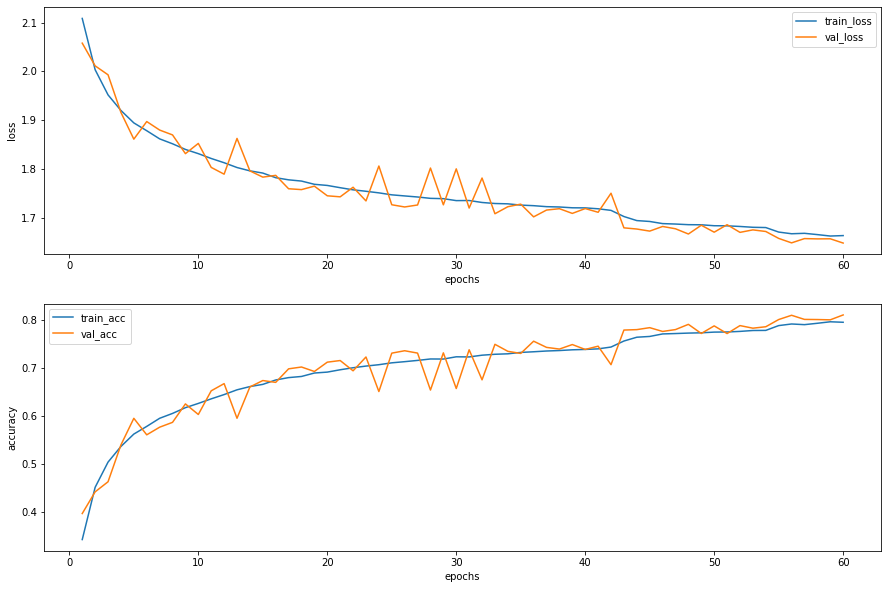

In [24]:
fix, axs = plt.subplots(nrows = 2, ncols = 1, figsize=(15,10))

axs[0].set_xlabel("epochs")
axs[0].set_ylabel("loss")
axs[0].plot(range(1,epochs+1),train_losses, label="train_loss")
axs[0].plot(range(1,epochs+1),val_losses, label="val_loss")
axs[0].legend()

axs[1].set_xlabel("epochs")
axs[1].set_ylabel("accuracy")
axs[1].plot(range(1,epochs+1),train_accuracies, label="train_acc")
axs[1].plot(range(1,epochs+1),val_accuracies, label="val_acc")
axs[1].legend()

# 5. Final model accuracy on **CIFAR-10 Validation Set**:

In [25]:
running_loss = 0.0
running_correct = 0
running_counter = 0
model.eval()
with torch.no_grad():
    for i, data in enumerate(test_dataloader, 0):
      inputs, labels = data
      inputs = inputs.cuda()
      labels = labels.cuda()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      running_loss += loss.item() * inputs.size(0)
      running_counter += inputs.size(0)

      _, predicted = torch.max(outputs.data, 1)
      running_correct += (predicted == labels).sum().item()
    val_loss = running_loss / len(test_dataloader.dataset)
    val_accuracy = running_correct/running_counter

print("validation loss: ",val_loss)
print("validation accuracy: ", val_accuracy)

validation loss:  1.6494630260467529
validation accuracy:  0.8113
